In [3]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)


In [4]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0


In [5]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 

In [6]:
print('LL_PDC:', view_1hot_df.columns.get_loc('LL_PDC'))
#print('Unique LL_PDC:', np.unique(train_v[:, 28]))

LL_PDC: 28


In [18]:
def set_up_xy(time_series, scaled_time_series):
    num_of_inds = time_series.shape[0]//28
    n_features = time_series.shape[1]
    
    _x = np.empty((num_of_inds, 
                   n_features+(n_features-1)*7), 
                   dtype='float')
    _y = np.empty((num_of_inds, 2), dtype='float') # 3, 
    ###############################################
    # construct x and y  flatten times series 
    # to 1 row.
    ###############################################
    for i in range(num_of_inds):
        scaled_ind_v = copy.deepcopy(scaled_time_series[(i*28):((i+1)*28), :])
        _x[i, :n_features] = copy.deepcopy(scaled_ind_v[0, :])
        for j in range(1, 8):
            start_idx = (j-1)*(n_features-1)+n_features
            end_idx = start_idx + (n_features-1)
            _x[i, start_idx:end_idx] = copy.deepcopy(scaled_ind_v[j, 1:])
        ind_v = copy.deepcopy(time_series[(i*28):((i+1)*28), :])
        if sum(ind_v[8:28, 28])/20 >= 80:
            _y[i, 0] = 0.0
            _y[i, 1] = 1.0
        else:
            _y[i, 0] = 1.0
            _y[i, 1] = 0.0
    return _x, _y

In [8]:
print(train_v.shape)
print(scaled_train.shape)

x_train, y_train = set_up_xy(train_v, scaled_train)

#x_train, y_train = set_up_xy_aggregate(scaled_train)
#x_test, y_test = set_up_xy_aggregate(scaled_test)
print("x train", x_train.shape)
print("y train", y_train.shape)

(2520000, 182)
(2520000, 182)
x train (90000, 1449)
y train (90000, 2)


In [9]:
def set_up_model(n_units, dropout_rate_1, dropout_rate_2):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', 
                    #kernel_regularizer=regularizers.l2(0.01),
                    input_shape=(1449, ))) #1449, 1457
    model.add(Dropout(dropout_rate_1))
    model.add(Dense(n_units, activation='relu'))
                    #kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout_rate_2))
    model.add(Dense(2, activation='softmax')) #20
                   #kernel_regularizer=regularizers.l2(0.01)))
    #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-4)  #1e-4
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
def fit_model(model, X_train, Y_train, b_size):
    val_weight = "MLP_val_weights.hdf5"
    val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                         monitor='val_loss', verbose=1,
                                         save_best_only=True)
    history = model.fit(X_train, Y_train,
                        batch_size=b_size, 
                        epochs=50, 
                        validation_split=0.1, 
                        callbacks=[val_checkpointer], 
                        verbose=2, 
                        shuffle=False)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    return min(history.history['val_loss'])

In [1]:
from numpy.random import seed
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units_list = [4, 8, 16, 32, 64, 128, 256] 
batch_size_list = [128, 256, 512, 1024, 2048] 

start_time = time.time()

exp_record = []

for n_units in units_list:
    for b_size in batch_size_list:
        for f in range(5):#10
            #start = f*num_per_fold
            end = (f+1)*num_per_fold
            train1_x = x_train[:end, ]
            train2_x = x_train[end:, ]
            train_x_mlp = np.append(train2_x, train1_x, axis=0) #new obj
            train1_y = y_train[:end, ]
            train2_y = y_train[end:, ]
            train_y_mlp = np.append(train2_y, train1_y, axis=0)

            start_time_inner = time.time()
            with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
                model = set_up_model(n_units, 0.25, 0.25)
                v_loss = fit_model(model, train_x_mlp,
                                   train_y_mlp, b_size)
                print("#################################")
                print("Number of units:", n_units)
                print("Batch size:", b_size)
                print("Fold:", f)
                print("best val loss:", v_loss)
                exp_record.append([n_units, b_size, f, v_loss])
                print("#################################")
            if (f==4):
                print(exp_record)
            end_time = time.time()
            print("Time to train MLP: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

Experiment record:
[[4, 128, 0, 0.5414573936462402], [4, 128, 1, 0.5455744078159332], [4, 128, 2, 0.5486198019451565], [4, 128, 3, 0.5711020894580418], [4, 128, 4, 0.5540316669676039], [4, 256, 0, 0.5432607687049442], [4, 256, 1, 0.5508816653357612], [4, 256, 2, 0.5487729122373793], [4, 256, 3, 0.564911727004581], [4, 256, 4, 0.5477240006658766], [4, 512, 0, 0.5423542895317077], [4, 512, 1, 0.5469471882714165], [4, 512, 2, 0.5500648667547438], [4, 512, 3, 0.5497734956211514], [4, 512, 4, 0.5468332695960999], [4, 1024, 0, 0.5579566084014045], [4, 1024, 1, 0.5459850067032708], [4, 1024, 2, 0.5542468477884929], [4, 1024, 3, 0.5546588684187995], [4, 1024, 4, 0.5453663501209682], [4, 2048, 0, 0.545304788324568], [4, 2048, 1, 0.545630897363027], [4, 2048, 2, 0.5591323220464919], [4, 2048, 3, 0.5579824616114298], [4, 2048, 4, 0.5499384236335755], [8, 128, 0, 0.5324733752674526], [8, 128, 1, 0.5341038670539856], [8, 128, 2, 0.5445475633409288], [8, 128, 3, 0.5485048755009969], [8, 128, 4, 0.53

In [5]:
complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(35):
    h_params = complete_v[(i*5):((i+1)*5), :]
    print("###############################")
    print("Units:", h_params[0, 0])
    print("Batch size:", h_params[0, 1])
    #print("Val loss (mean):", np.mean(h_params[:, 3]))
    #print("Val loss (std):", np.std(h_params[:, 3]))
    print("Val loss (mean):", 
          np.round(np.mean(h_params[:, 3]), decimals=5))
    print("Val loss (std):", 
          np.round(np.std(h_params[:, 3]), decimals=5))
    print("###############################")
    val_loss_list.append(np.mean(h_params[:, 3]))
print(min(val_loss_list))

(175, 4)
###############################
Units: 4.0
Batch size: 128.0
Val loss (mean): 0.55216
Val loss (std): 0.01032
###############################
###############################
Units: 4.0
Batch size: 256.0
Val loss (mean): 0.55111
Val loss (std): 0.00734
###############################
###############################
Units: 4.0
Batch size: 512.0
Val loss (mean): 0.54719
Val loss (std): 0.00278
###############################
###############################
Units: 4.0
Batch size: 1024.0
Val loss (mean): 0.55164
Val loss (std): 0.00504
###############################
###############################
Units: 4.0
Batch size: 2048.0
Val loss (mean): 0.5516
Val loss (std): 0.00592
###############################
###############################
Units: 8.0
Batch size: 128.0
Val loss (mean): 0.53866
Val loss (std): 0.00657
###############################
###############################
Units: 8.0
Batch size: 256.0
Val loss (mean): 0.53871
Val loss (std): 0.00719
############################

In [22]:
n_units = 4
model = Sequential()
model.add(Dense(n_units, activation='relu', 
                    #kernel_regularizer=regularizers.l2(0.01),
                    input_shape=(1449, ))) #1457
model.add(Dropout(0.25))
model.add(Dense(n_units, activation='relu'))
                    #kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax')) #20
                   #kernel_regularizer=regularizers.l2(0.01)))
#sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-4)  #1e-4
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_319 (Dense)            (None, 4)                 5800      
_________________________________________________________________
dropout_213 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_320 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_214 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_321 (Dense)            (None, 20)                100       
Total params: 5,920
Trainable params: 5,920
Non-trainable params: 0
_________________________________________________________________


In [11]:
###########################
# generate random numbers
# for dropout rate
###########################
from numpy.random import seed
seed(8)
# dropout rate for 1st dropout
# layer (between 0.0 and 0.5)
dropout_rate_1_list = []
for i in range(25):
    dropout_rate_1_list.append(np.random.uniform(0.0, 0.5))
# dropout rate for 2nd dropout
# layer (between 0.0 and 0.5)
dropout_rate_2_list = []
for i in range(25):
    dropout_rate_2_list.append(np.random.uniform(0.0, 0.5))
print(min(dropout_rate_1_list))
print(max(dropout_rate_1_list))
print(min(dropout_rate_2_list))
print(max(dropout_rate_2_list))
print(dropout_rate_1_list)
print(dropout_rate_2_list)

0.0056994021387149485
0.4914352732767169
0.014366024481647699
0.49429825905686464
[0.4367147013959081, 0.484270331410466, 0.43459727010696, 0.2654278457777995, 0.11636416398864535, 0.0056994021387149485, 0.21523440914624525, 0.2011756800186824, 0.2613373356762848, 0.23919589790120122, 0.2776782369111652, 0.2716930087712702, 0.3804477878014645, 0.35618728704104563, 0.3098410480517198, 0.2130458852380961, 0.14453751400904385, 0.4869276206002231, 0.16688702275533518, 0.10940053040991399, 0.032904193893605715, 0.4914352732767169, 0.06392785646251592, 0.16106539660208968, 0.03547142237509937]
[0.11238496948402271, 0.19681745747180246, 0.4480725024403176, 0.17273080599893353, 0.49237471864263566, 0.014366024481647699, 0.17584236813506005, 0.1904794446019265, 0.38208006568298003, 0.46940195665538587, 0.15984489823351383, 0.21623796639520793, 0.13507287079573266, 0.40052794316319723, 0.31911940306156067, 0.03434506672907861, 0.3018222381845556, 0.3977872792144883, 0.0160040782128984, 0.2277239

In [6]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

start_time = time.time()

n_units = 64
b_size = 256

exp_record = []

for i in range(25):
    dropout_rate_1 = dropout_rate_1_list[i]
    dropout_rate_2 = dropout_rate_2_list[i]

    for f in range(5):#10
        #start = f*num_per_fold
        end = (f+1)*num_per_fold
        train1_x = x_train[:end, ]
        train2_x = x_train[end:, ]
        train_x_mlp = np.append(train2_x, train1_x, axis=0) #new obj
        train1_y = y_train[:end, ]
        train2_y = y_train[end:, ]
        train_y_mlp = np.append(train2_y, train1_y, axis=0)

        start_time_inner = time.time()
        with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
            model = set_up_model(n_units, 
                                 dropout_rate_1, 
                                 dropout_rate_2)
            v_loss = fit_model(model, train_x_mlp, 
                               train_y_mlp, b_size)
            print("#################################")
            print("Number of units:", n_units)
            print("Batch size:", b_size)
            print("Dropout rate 1:", dropout_rate_1)
            print("Dropout rate 2:", dropout_rate_2)
            print("Fold:", f)
            print("Best val loss:", v_loss)
            exp_record.append([n_units, b_size, 
                               dropout_rate_1, 
                               dropout_rate_2, 
                               f, v_loss])
            print("#################################")
            if(f==4):
                print(exp_record)
        print("Time to train MLP: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

Experiment record:
[[64, 256, 0.4367147013959081, 0.11238496948402271, 0, 0.5320906109015147], [64, 256, 0.4367147013959081, 0.11238496948402271, 1, 0.5365452956093683], [64, 256, 0.4367147013959081, 0.11238496948402271, 2, 0.5440627681944106], [64, 256, 0.4367147013959081, 0.11238496948402271, 3, 0.5443761173354255], [64, 256, 0.4367147013959081, 0.11238496948402271, 4, 0.5304479742579989], [64, 256, 0.484270331410466, 0.19681745747180246, 0, 0.5311833881802029], [64, 256, 0.484270331410466, 0.19681745747180246, 1, 0.5321658252610101], [64, 256, 0.484270331410466, 0.19681745747180246, 2, 0.5456108359230889], [64, 256, 0.484270331410466, 0.19681745747180246, 3, 0.5482097542021009], [64, 256, 0.484270331410466, 0.19681745747180246, 4, 0.5348042809168497], [64, 256, 0.43459727010696, 0.4480725024403176, 0, 0.5274559156629774], [64, 256, 0.43459727010696, 0.4480725024403176, 1, 0.5325525876945919], [64, 256, 0.43459727010696, 0.4480725024403176, 2, 0.5391674257384406], [64, 256, 0.4345972

In [7]:
complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(25):
    model_v = complete_v[(i*5):((i+1)*5), :]
    print("#######################")
    print("Units:\t\t", model_v[0, 0])
    print("Batch size:\t", model_v[0, 1])
    print("Dropout rate 1:\t", model_v[0, 2])
    print("Dropout rate 2:\t", model_v[0, 3])
    print("Val loss (mean):", np.mean(model_v[:, 5]))
    print("Val loss (Std): ", np.std(model_v[:, 5]))
    print("#######################")
    val_loss_list.append(np.mean(model_v[:, 5]))
print(min(val_loss_list))

(125, 6)
#######################
Units:		 64.0
Batch size:	 256.0
Dropout rate 1:	 0.4367147013959081
Dropout rate 2:	 0.11238496948402271
Val loss (mean): 0.5375045532597436
Val loss (Std):  0.005835320561569573
#######################
#######################
Units:		 64.0
Batch size:	 256.0
Dropout rate 1:	 0.484270331410466
Dropout rate 2:	 0.19681745747180246
Val loss (mean): 0.5383948168966505
Val loss (Std):  0.007100717068738486
#######################
#######################
Units:		 64.0
Batch size:	 256.0
Dropout rate 1:	 0.43459727010696
Dropout rate 2:	 0.4480725024403176
Val loss (mean): 0.5336316456529828
Val loss (Std):  0.0053829970162959685
#######################
#######################
Units:		 64.0
Batch size:	 256.0
Dropout rate 1:	 0.2654278457777995
Dropout rate 2:	 0.17273080599893353
Val loss (mean): 0.5346299292034572
Val loss (Std):  0.006448232413789457
#######################
#######################
Units:		 64.0
Batch size:	 256.0
Dropout rate 1:	 0.116364

In [8]:
x = np.array([4, 8, 16, 32, 64, 128, 256])
y = np.array([128, 256, 512, 1024, 2048])
complete_list = [[0.55216,0.53866,0.53473,0.53379,0.5345,0.53529,0.53724],
                 [0.55111,0.53871,0.53444,0.5343,0.53333,0.53335,0.53509],
                 [0.54719,0.53957,0.53676,0.53526,0.53338,0.53367,0.53528],
                 [0.55164,0.5415,0.53927,0.53559,0.53405,0.53543,0.53587],
                 [0.5516,0.54238,0.53909,0.53899,0.53733,0.5367,0.53821]]
X,Y = np.meshgrid(x, y)
print(X)
print(Y)
print(np.round(complete_list, decimals=5))

[[  4   8  16  32  64 128 256]
 [  4   8  16  32  64 128 256]
 [  4   8  16  32  64 128 256]
 [  4   8  16  32  64 128 256]
 [  4   8  16  32  64 128 256]]
[[ 128  128  128  128  128  128  128]
 [ 256  256  256  256  256  256  256]
 [ 512  512  512  512  512  512  512]
 [1024 1024 1024 1024 1024 1024 1024]
 [2048 2048 2048 2048 2048 2048 2048]]
[[0.55216 0.53866 0.53473 0.53379 0.5345  0.53529 0.53724]
 [0.55111 0.53871 0.53444 0.5343  0.53333 0.53335 0.53509]
 [0.54719 0.53957 0.53676 0.53526 0.53338 0.53367 0.53528]
 [0.55164 0.5415  0.53927 0.53559 0.53405 0.53543 0.53587]
 [0.5516  0.54238 0.53909 0.53899 0.53733 0.5367  0.53821]]


(5, 7)
(5, 7)
(5, 7)


<IPython.core.display.Javascript object>


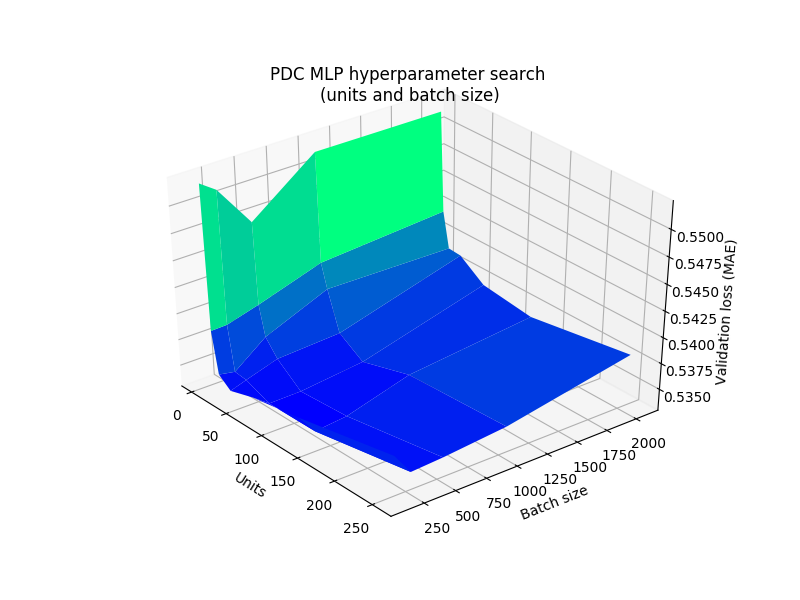

In [9]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d    
from mpl_toolkits import mplot3d

X,Y = np.meshgrid(x, y)
z = np.array(complete_list)
print(X.shape)
print(Y.shape)
print(z.shape)
fig = pyplot.figure(figsize=(8, 6))
ax = pyplot.axes(projection='3d')

ax.set_xlabel('Units')
ax.set_ylabel('Batch size')
ax.set_zlabel('Validation loss (MAE)')

ax.plot_surface(X, Y, z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title('PDC MLP hyperparameter search \n(units and batch size)')
pyplot.show()

(125, 6)
(25, 3)


<IPython.core.display.Javascript object>


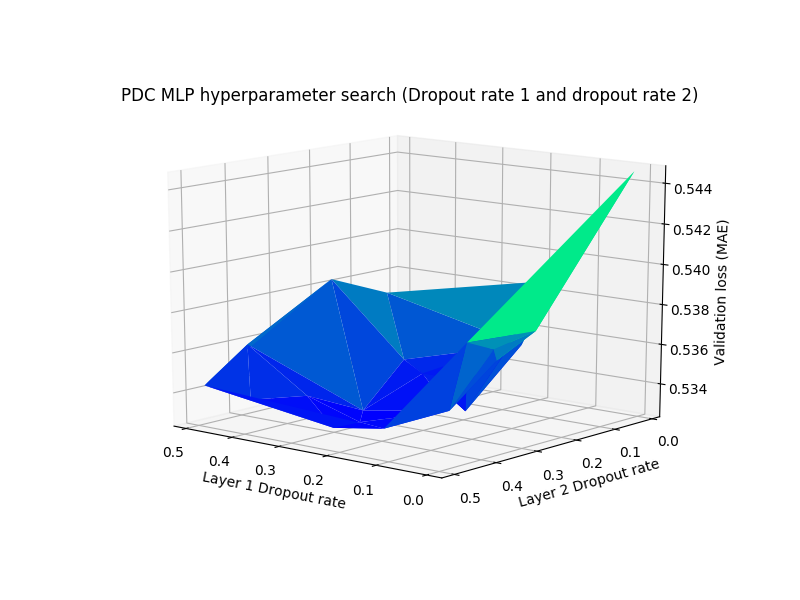

Text(0.5, 0.92, 'PDC MLP hyperparameter search (Dropout rate 1 and dropout rate 2)')

In [12]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D   
from mpl_toolkits import mplot3d

complete_v = np.array(exp_record)
print(complete_v.shape)
xyz = []
for i in range(25):
    fold_v = complete_v[(i*5):((i+1)*5), :]
    xyz.append([fold_v[0, 2], 
                fold_v[0, 3], 
                np.mean(fold_v[:, 5])])
xyz_v = np.array(xyz)
print(xyz_v.shape)


fig = pyplot.figure(figsize=(8, 6))

ax = pyplot.axes(projection='3d')
ax.set_xlabel('Layer 1 Dropout rate')
ax.set_ylabel('Layer 2 Dropout rate')
ax.set_zlabel('Validation loss (MAE)')

ax.plot_trisurf(xyz_v[:, 0], xyz_v[:, 1], xyz_v[:, 2],
               cmap='winter', edgecolor='none')
ax.set_title('PDC MLP hyperparameter search (Dropout rate 1 and dropout rate 2)')